# Law Chatbot Using Retrieval Augmented Generation (RAG)

This project aims to develop a Large Language Model (LLM) with Retrieval Augmented Generation (RAG) support.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The primary goal of Retrieval-Augmented Generation (RAG) is to enhance the output quality of large language models (LLMs).

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are powerful but can sometimes generate plausible yet incorrect information. RAG pipelines mitigate this by providing factual inputs, leading to more accurate outputs. Even if the answer from a RAG pipeline is questionable, the retrieval process provides access to the original sources, ensuring transparency.
2. **Work with custom data** - While base LLMs excel at general language tasks due to their broad training on internet-scale text, they often lack specific domain knowledge. RAG systems address this by supplying LLMs with specialized data, such as medical records or corporate documentation, tailoring their outputs to specific applications.

## Setting Up Our Workspace

**Fetching Necessary Libraries**

In [1]:
import os

if "COLAB_GPU" in os.environ:
    print(" Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

 Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64.whl size=191363917 sha256=b1243e9b86687348a5ab03a073abacdf8e3d5e9e4b7e5326a183f47348c5dfba
  Stored in directory: /root/.cache/pip/wheels/d0/a3/f9/48d2706cb2eac05ec0dc144bf6954fe47bb3c2cd0de280765e
Successfully built flash-attn


## Building Our Pipeline

###  1. Text Processing

Steps:

1. Import the PDF document(s).
2. Prepare the text for embedding by segmenting it into chunks of sentences.

**Importing PDF Documents**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can import the pages of our PDF(s) as text by first defining the PDF paths and then opening and reading it with PyMuPDF (`import fitz`).

In [3]:
import os

# Get PDF document
dir_path = "/content/drive/MyDrive/Colab Notebooks/LawBot Docs/"

filenames = [] # Loop through the files in the specified directory
for filename in os.listdir(dir_path):
  # Check if it is a file (excluding directories)
  if os.path.isfile(os.path.join(dir_path, filename)):
    filenames.append(os.path.join(dir_path, filename))

In [4]:
filenames[:1]

['/content/drive/MyDrive/Colab Notebooks/LawBot Docs/CONSTITUTION OF INDIA.pdf']

We'll write a small helper function to preprocess the text as it gets read and save each page to a dictionary and then append that dictionary to a list for ease of use later.

> **Resource:** [PyMuPDF](https://github.com/pymupdf/pymupdf)

In [5]:
import fitz # (package name for pymupdf)
from tqdm.auto import tqdm # for progress bars

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("  +", " ") # removing empty spaces
    cleaned_text = text.replace("_+", "") # removing underlines
    cleaned_text = text.replace("\n", " ").strip() # replacing new lines with spaces
    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the document name, page number,
        character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"doc_name": os.path.basename(pdf_path),
                                "page_number": page_number + 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars,
                                "text": text})
    return pages_and_texts

pages_and_texts = []
for filename in filenames:
    pages_and_texts.extend(open_and_read_pdf(pdf_path=filename))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Checking out first two pages of the first PDF**

In [6]:
pages_and_texts[:2]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'},
 {'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'page_char_count': 891,
  'page_word_count': 151,
  'page_sentence_count_raw': 7,
  'page_token_count': 222.75,
  'text': 'PREFACE This is the  sixth pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorporating therein all the amendments up to the Constitution  (One Hundred and Sixth Amendment) Act, 2023. The foot notes  below the text indicate the Constitution Amendment Acts by  which such amendments have been made.  The Constitution (One Hun

**Getting some statistics**

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

In [7]:
import pandas as pd
import random

df = pd.DataFrame(pages_and_texts)
df.sample(n=10)

,doc_name,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
216,CONSTITUTION OF INDIA.pdf,217,2377,394,9,594.25,"186 PART XV ELECTIONS 324. Superintendence, di..."
1867,Company Law.pdf,928,2493,473,8,623.25,928 EP-CL out all such facts as would enabl...
1555,Company Law.pdf,616,3597,640,15,899.25,"616 EP-CL ownership under subsection (1.4),..."
262,CONSTITUTION OF INDIA.pdf,263,2273,410,11,568.25,THE CONSTITUTION OF INDIA (Part XXI.—Temporar...
896,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,391,2519,447,19,629.75,Lesson 16 n The Protection of Plant Varieties...
78,CONSTITUTION OF INDIA.pdf,79,2220,422,11,555.00,THE CONSTITUTION OF INDIA (Part V.—The Union)...
392,CONSTITUTION OF INDIA.pdf,393,1286,215,29,321.50,THE CONSTITUTION OF INDIA (Appendix I) 362 1...
1371,Company Law.pdf,432,3464,612,15,866.00,432 EP-CL \t (g)\t whether securities have ...
1666,Company Law.pdf,727,3760,606,21,940.00,Lesson 17 n Appointment and Remuneration of Ke...
1650,Company Law.pdf,711,1342,236,4,335.50,Lesson 17 n Appointment and Remuneration of Ke...


In [8]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67
std,256.78,895.10,153.40,9.79,223.78
min,1.00,11.00,5.00,1.00,2.75
25%,123.00,2312.50,412.00,10.00,578.12
50%,280.00,2947.00,515.00,15.00,736.75
75%,475.50,3462.50,601.50,23.00,865.62
max,947.00,4802.00,864.00,93.00,1200.50


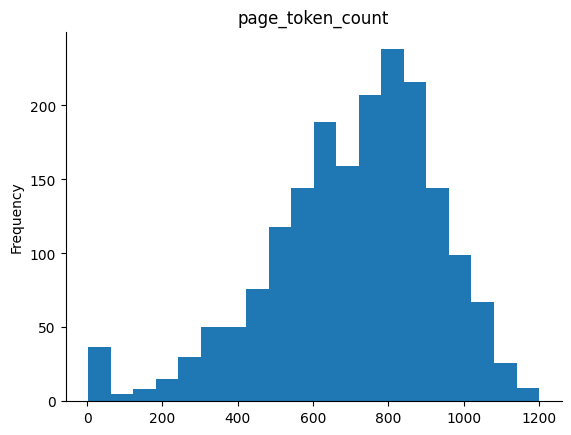

In [9]:
from matplotlib import pyplot as plt
df['page_token_count'].plot(kind='hist', bins=20, title='page_token_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Further text processing**

We want to split pages into sentences and chunk them for easier embedding.

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

> **Resource:** [spaCy install instructions](https://spacy.io/usage).

In [10]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1887 [00:00<?, ?it/s]

In [11]:
pages_and_texts[:4]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING',
  'sentences': ['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'],
  'page_sentence_count_spacy': 1},
 {'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'page_char_count': 891,
  'page_word_count': 151,
  'page_sentence_count_raw': 7,
  'page_token_count': 222.75,
  'text': 'PREFACE This is the  sixth pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorpor

Let's review the new statistics.

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67,16.60
std,256.78,895.10,153.40,9.79,223.78,9.19
min,1.00,11.00,5.00,1.00,2.75,1.00
25%,123.00,2312.50,412.00,10.00,578.12,10.00
50%,280.00,2947.00,515.00,15.00,736.75,16.00
75%,475.50,3462.50,601.50,23.00,865.62,22.00
max,947.00,4802.00,864.00,93.00,1200.50,76.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

On average each of our pages has ~16 sentences and an average total of ~751 tokens per page.

So if we take groups of 8 sentences, then it will be ~375 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 8

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1887 [00:00<?, ?it/s]

In [14]:
pages_and_texts[:1]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING',
  'sentences': ['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'],
  'page_sentence_count_spacy': 1,
  'sentence_chunks': [['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING']],
  'num_chunks': 1}]

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67,16.60,2.52
std,256.78,895.10,153.40,9.79,223.78,9.19,1.17
min,1.00,11.00,5.00,1.00,2.75,1.00,1.00
25%,123.00,2312.50,412.00,10.00,578.12,10.00,2.00
50%,280.00,2947.00,515.00,15.00,736.75,16.00,2.00
75%,475.50,3462.50,601.50,23.00,865.62,22.00,3.00
max,947.00,4802.00,864.00,93.00,1200.50,76.00,10.00


**Creating a new dictionary of individul chunk items**

We aim to embed each chunk of sentences into its unique numerical representation.

To maintain clarity, we will create a list of dictionaries. Each dictionary will contain a single chunk of sentences along with relevant details such as the document name, page number and various statistics about the chunk.

In [16]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["doc_name"] = item["doc_name"]
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# Total no. of chunks
len(pages_and_chunks)

  0%|          | 0/1887 [00:00<?, ?it/s]

4754

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'doc_name': 'Company Law.pdf',
  'page_number': 812,
  'sentence_chunk': 'iii) \t Such Notice shall also be given to the Directors and Auditors of the company, to the Secretarial Auditor, to Debenture Trustees, if any, and, wherever applicable or so required, to other specified recipients.\t iv) \t In case of companies having a website, Notice of the postal ballot shall simultaneously be placed on the website.\t v) \t Notice shall specify the day, date, time and venue where the results of the voting by postal ballot will be announced and the link of the website where such results will be displayed. Notice shall also specify the mode of declaration of the results of the voting by postal ballot.\t vi)\t Notice of the postal ballot shall inform the Members about availability of e-voting facility, if any and provide necessary information thereof to enable them to access such facility.\t \t In case the facility of e-voting has been made available, the provisions relating to conduct of e-v

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,4754.00,4754.00,4754.00,4754.00
mean,315.18,1107.88,182.78,276.97
std,256.95,754.41,126.86,188.60
min,1.00,3.00,1.00,0.75
25%,106.00,466.00,76.00,116.50
50%,263.50,1053.00,172.00,263.25
75%,427.00,1550.75,257.75,387.69
max,947.00,4246.00,732.00,1061.50


It seems that some of our chunks have a relatively low token count.

Let's review the samples with fewer than 70 tokens (approximately the length of a sentence) to determine if they are worth retaining.

In [19]:
# Show random chunks with under 70 tokens in length
min_token_length = 70
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 56.25 | Text: 2. Subs.by the Constitution (Forty-first Amendment) Act, 1976, s. 2, for "sixty years" (w.e.f.7-9-1976).3. The words "or Rajpramukh" omitted by the Constitution (Seventh Amendment) Act, 1956, s. 29 and Sch. (w.e.f.1-11-1956).
Chunk token count: 56.5 | Text: a) re-lettered as cl. (aa) by the Constitution (Forty-fourth Amendment) Act, 1978, s. 28 (w.e.f.20-6-1979).5. Subs.by the Constitution (Forty-second Amendment) Act, 1976, s. 36, for "has held judicial office" (w.e.f.3-1-1977).
Chunk token count: 26.0 | Text: 7.1.2	 A distinct Minutes Book shall be maintained for Meetings of the Board and each of its Committees.
Chunk token count: 2.75 | Text: 21-1-1972).
Chunk token count: 41.75 | Text: ibid.,for "in Part A or Part B of the First Schedule" (w.e.f.1-11-1956).3. Ins.by the Constitution (One Hundred and First Amendment) Act, 2016, s. 2 (w.e.f.16-9-2016).


These don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 70 tokens in length.

In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'sentence_chunk': 'PREFACE This is the sixth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up-to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Sixth Amendment) Act, 2023. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in Appendix I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference. New Delhi; Dr. Rajiv Mani, 1st May, 2024 Secretary to the Government of India.',
  'chunk_char_count': 877,
  'chunk_